### Imports and global size parameters so mike can see it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
from scipy.optimize import curve_fit, minimize
from scipy.signal import fftconvolve
import numpy as np
plt.rcParams.update({
    'font.size': 13,          # Global default font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 14,     # Axis label font size
    'xtick.labelsize': 12,    # X tick size
    'ytick.labelsize': 12,    # Y tick size
    'legend.fontsize': 12,    # Legend font size
})

### Every function for the mane fitting

In [2]:
# --- Gaussian model ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

def get_initial_guess_gaussian(x, y, side=None):
    amp = np.max(y)
    mean = x[np.argmax(y)]
    half_max = amp / 2
    indices = np.where(y > half_max)[0]

    if len(indices) >= 2:
        fwhm = x[indices[-1]] - x[indices[0]]
    else:
        fwhm = (x[-1] - x[0]) / 2.0

    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

    # Adjust mean based on side to lie within the bounds
    if side == "left":
        mean = max(x) + 0.1 * (max(x) - min(x))
    elif side == "right":
        mean = min(x) - 0.1 * (max(x) - min(x))

    return [amp, mean, sigma]


def fit_single_gaussian(x, y, side="left"):
    p0 = get_initial_guess_gaussian(x, y,side=side)
    yerr = np.sqrt(np.clip(y, 1, None))
    
    # Apply constraints on mean depending on which side we are fitting
    if side == "left":
        bounds = ([0, max(x), 0], [np.inf, np.inf, np.inf])  # mean > max(x)
    elif side == "right":
        bounds = ([0, -np.inf, 0], [np.inf, min(x), np.inf])  # mean < min(x)
    else:
        raise ValueError("side must be 'left' or 'right'")

    popt, pcov = curve_fit(gaussian, x, y, sigma=yerr, absolute_sigma=True, p0=p0, bounds=bounds)
    y_fit = gaussian(x, *popt)
    residuals = y - y_fit
    chi2 = np.sum((residuals / yerr) ** 2)
    dof = len(x) - len(popt)
    chi2_red = chi2 / dof
    sigma = popt[2]
    sigma_err = np.sqrt(pcov[2, 2]) if np.isfinite(pcov[2, 2]) else np.nan
    return popt, sigma, sigma_err, chi2, chi2_red, y_fit, residuals, yerr


def fit_two_flanks_gaussian(x_flank_g, y_flank_g, plot_name_prefix=None,return_all = False):
    x_center = np.mean(x_flank_g)
    left_mask = x_flank_g < x_center
    right_mask = x_flank_g > x_center

    x_left, y_left = x_flank_g[left_mask], y_flank_g[left_mask]
    x_right, y_right = x_flank_g[right_mask], y_flank_g[right_mask]

    # Fit each side
    fit_left = fit_single_gaussian(x_left, y_left, side="left")
    fit_right = fit_single_gaussian(x_right, y_right, side="right")

    # Unpack
    _, sigma_l, sigma_err_l, chi2_l, chi2red_l, y_fit_l, res_l, yerr_l = fit_left
    _, sigma_r, sigma_err_r, chi2_r, chi2red_r, y_fit_r, res_r, yerr_r = fit_right

    # Average resolution
    sigma_avg = (sigma_l + sigma_r) / 2
    sigma_avg_err = np.sqrt((sigma_err_l ** 2 + sigma_err_r ** 2) / 4)

    # Print results
    print("--- Two-Gaussian Flank Fit ---")
    print(f"Left  σ = {sigma_l:.4f} ± {sigma_err_l:.4f}, χ²/ν = {chi2red_l:.2f}")
    print(f"Right σ = {sigma_r:.4f} ± {sigma_err_r:.4f}, χ²/ν = {chi2red_r:.2f}")
    print(f"\nAverage Timing Resolution: σ = {sigma_avg:.4f} ± {sigma_avg_err:.4f} ns")

    # --- Plot Fit ---
    plt.figure(figsize=(10, 5))
    plt.errorbar(x_left, y_left, yerr=yerr_l, fmt='o', label="Left Flank", alpha=0.7)
    plt.plot(x_left, y_fit_l, label="Fit Left", color='tab:blue')
    plt.errorbar(x_right, y_right, yerr=yerr_r, fmt='o', label="Right Flank", alpha=0.7)
    plt.plot(x_right, y_fit_r, label="Fit Right", color='tab:green')
    plt.title("Two-Gaussian Flank Fits")
    plt.xlabel("Time difference (ns)")
    plt.ylabel("Counts")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    if plot_name_prefix:
        plt.savefig(f"{plot_name_prefix}_fit.jpg", dpi=300)
    plt.show()

    # --- Residuals ---
    plt.figure(figsize=(10, 4))
    plt.axhline(0, color='black', linestyle='--')
    plt.errorbar(x_left, res_l, yerr=yerr_l, fmt='o', markersize=4, label="Residuals Left", alpha=0.7)
    plt.errorbar(x_right, res_r, yerr=yerr_r, fmt='o', markersize=4, label="Residuals Right", alpha=0.7)
    plt.title("Residuals of Two-Gaussian Flank Fits")
    plt.xlabel("Time difference (ns)")
    plt.ylabel("Residual (Data - Fit)")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    if plot_name_prefix:
        plt.savefig(f"{plot_name_prefix}_residuals.jpg", dpi=300)
    plt.show()

    if return_all:
        return sigma_avg, sigma_avg_err, sigma_l, sigma_err_l, chi2red_l, sigma_r, sigma_err_r, chi2red_r
    return sigma_avg, sigma_avg_err

def get_flank_mask_yonly(x, y, threshold_frac=0.95):
    """
    Return a mask for the flanks by removing only the top (flat) region.
    threshold_frac: fractional height of max(y) to define top to exclude
    """
    y = np.array(y)
    y_max = np.max(y)
    return y < (threshold_frac * y_max)
def get_flank_mask_slope_based(x, y, buffer_bins=2, slope_threshold_frac=0.1):
    """
    Create a mask that captures the falling edges (flanks) of the square wave
    using the derivative to find transition zones.
    
    buffer_bins: how many bins to keep around each flank
    slope_threshold_frac: fraction of max slope used to detect edge regions
    """
    x = np.array(x)
    y = np.array(y)

    dy = np.gradient(y, x)
    dy_abs = np.abs(dy)
    slope_max = np.max(dy_abs)
    slope_thresh = slope_threshold_frac * slope_max

    # Find where slope exceeds threshold — this gives flank zones
    flank_indices = np.where(dy_abs > slope_thresh)[0]

    # Initialize mask to all False
    mask = np.zeros_like(y, dtype=bool)

    # Turn on buffer regions around detected slopes
    for idx in flank_indices:
        start = max(0, idx - buffer_bins)
        end = min(len(y), idx + buffer_bins + 1)
        mask[start:end] = True

    return mask
def fit_gaussian_flanks(x, y, yerr, p0, buffer_bins=5, slope_threshold_frac=0.05):
    """
    Fit only the flanks of the data with a plain Gaussian (no convolution).
    """
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)

    mask = get_flank_mask_slope_based(x, y, buffer_bins=buffer_bins, slope_threshold_frac=slope_threshold_frac)
    x_flank = x[mask]
    y_flank = y[mask]
    yerr_flank = yerr[mask]

    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(gaussian, x_flank, y_flank, sigma=yerr_flank, absolute_sigma=True, p0=p0)

    y_fit = gaussian(x_flank, *popt)
    residuals = y_flank - y_fit
    chi2 = np.sum((residuals / yerr_flank) ** 2)
    dof = len(x_flank) - len(popt)
    chi2_red = chi2 / dof

    return popt, pcov, chi2, chi2_red, x_flank, y_flank, y_fit

def scan_slope_flank_grid(x, y, yerr, func, p0, buffer_vals, slope_vals):
    """
    Grid search for best fit quality using slope-based flank masking.
    
    Parameters:
    - x, y, yerr: input data arrays
    - func: model function (e.g. convolve_fixed_1gauss)
    - p0: initial parameter guess
    - buffer_vals: list of buffer_bins to scan
    - slope_vals: list of slope_threshold_frac values to scan

    Returns:
    - results: list of (buffer, slope_thresh, sigma, chi2_red)
    """
    results = []
    for buffer in buffer_vals:
        for slope in slope_vals:
            try:
                popt, chi2, chi2_red, _, _, _ = fit_chopped_1gauss_flanks(
                    x, y, yerr, func, p0,
                    buffer_bins=buffer,
                    slope_threshold_frac=slope
                )
                sigma = popt[3]
                results.append((buffer, slope, sigma, chi2_red))
            except:
                results.append((buffer, slope, None, None))
    return results


### File reading(due it whenever you want different data)

In [27]:
# how to open a root file in python
# Edit this here to run on any file
with uproot.open("/Users/sidne/DarkLight 2025/output00358.root") as f:
    fileID = "dltdc8_pair2_t_02_10_ns_cut_twc" # this is the nicest plot, start here then try t58ns_1458
    timeDiff = f["dltdc"][fileID].to_numpy()[0] #y data
    #t14 = f["dltdc"]["t14ns_1458"].to_numpy()[0]
    #t58 = f["dltdc"]["t58ns_1458"].to_numpy()[0]
    #t23 = f["dltdc"]["t23ns_2367"].to_numpy()[0]
    #t67 = f["dltdc"]["t67ns_2367"].to_numpy()[0]
    x_root = f["dltdc"][fileID].to_numpy()[1][0:-1] #x data
    
    timeDiff_firstHalf = timeDiff[0:int(len(timeDiff)/2)]
    timeDiff_lastHalf = timeDiff[int(len(timeDiff)/2):-1]

    
    #Store index where the data is 10% of the max value for that portion of data
    first10pmaxIndex = 0
    last10pmaxIndex = 0
    threshold = 0.15 #Proportion of the max we want to cut at (choose data greater than this proportion of the max)
    foundMax = 0 #Switch to be changed once we find the point crossing the threshold of the max of that part of the data
    i = 0
    j = 0

    while (foundMax == 0) and (i < len(timeDiff_firstHalf)):
        
        if timeDiff_firstHalf[i] > threshold*max(timeDiff_firstHalf):
            first10pmaxIndex = i
            foundMax = 1            
        i = i+1
        
    while (foundMax != 2) and (j < len(timeDiff_lastHalf)):
        
        if timeDiff_lastHalf[len(timeDiff_lastHalf) - 1 - j] > threshold*max(timeDiff_lastHalf):
            last10pmaxIndex = len(timeDiff_lastHalf) - 1 - j
            foundMax = 2            
        j = j+1
            
    #Cut data
    timeDiff_cut = timeDiff[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    x_root_cut = x_root[first10pmaxIndex:len(timeDiff_firstHalf)+last10pmaxIndex]
    
    #Calculate y error bars
    y_err = []
    for i in range(len(timeDiff)):
        y_err.append(np.sqrt(timeDiff[i]))
        
    y_err_cut = []
    for i in range(len(timeDiff_cut)):
        y_err_cut.append(np.sqrt(timeDiff_cut[i]))
        
        
    # NEW FOR CHOPPING OFF THE TOP
    peakHeight = max(timeDiff_cut)
    countsChopped_cut = np.zeros(len(timeDiff_cut))
    countsChopped_cut.tolist()
    
    for i in range(len(timeDiff_cut)):
        if timeDiff_cut[i]>((1-threshold)*peakHeight):
            countsChopped_cut[i] = (1-threshold)*peakHeight
        
        else:
            countsChopped_cut[i] = timeDiff_cut[i]
                  
#plt.plot(x_root_cut,timeDiff_cut)


KeyInFileError: not found: 'dltdc8_pair2_t_02_10_ns_cut_twc' (with any cycle number)

    Available keys: (none!)

in file /Users/sidne/DarkLight 2025/output00358.root

### Example Run of data

--- Two-Gaussian Flank Fit ---
Left  σ = 0.4364 ± 0.0139, χ²/ν = 0.56
Right σ = 0.4576 ± 0.0285, χ²/ν = 1.16

Average Timing Resolution: σ = 0.4470 ± 0.0158 ns


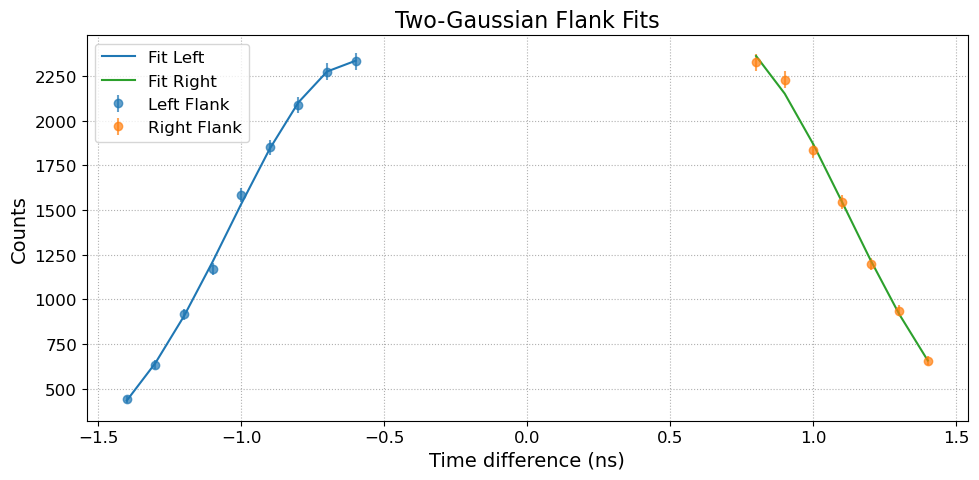

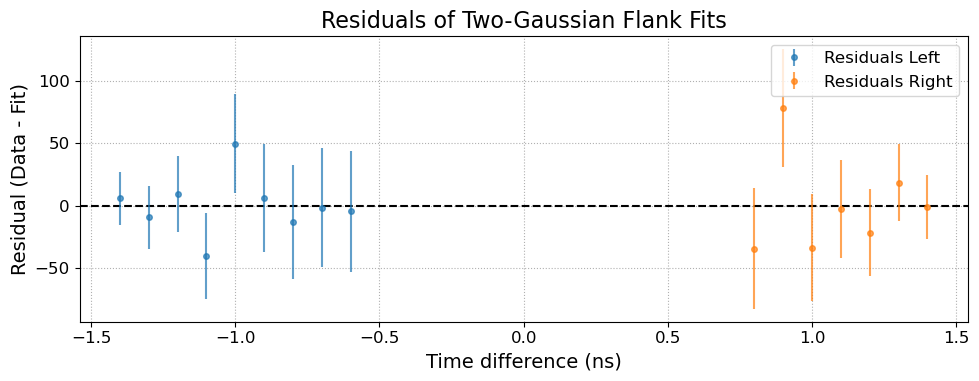

(0.44697898958699034, 0.015846212018779587)

In [4]:
flank_mask = get_flank_mask_slope_based(x_root_cut, countsChopped_cut, buffer_bins=0, slope_threshold_frac=0.05)
x_flank_g = x_root_cut[flank_mask]
y_flank_g = countsChopped_cut[flank_mask]

fit_two_flanks_gaussian(x_flank_g, y_flank_g, "test1")

### Data Demonstrator

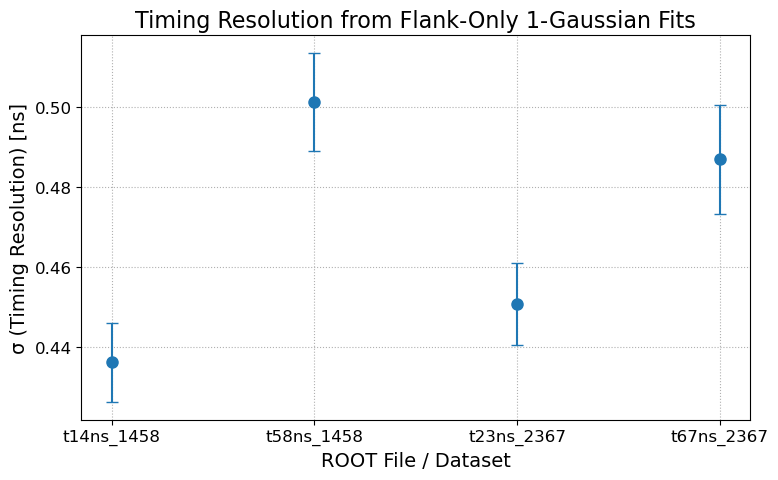

In [5]:


file_names = ["t14ns_1458", "t58ns_1458", "t23ns_2367", "t67ns_2367"]
timing_sigmas = [0.4362, 0.5011, 0.4508, 0.4868]  # from flank fits



timing_errors = [0.0099, 0.0123, 0.0103, 0.0135]  # same length as timing_sigmas

plt.figure(figsize=(8, 5))

# Scatter with vertical error bars only, no lines between points
plt.errorbar(file_names, timing_sigmas, yerr=timing_errors, fmt='o',
             markersize=8, capsize=4, elinewidth=1.5, color='tab:blue')

# Labels and formatting
plt.ylabel("σ (Timing Resolution) [ns]", fontsize=14)
plt.xlabel("ROOT File / Dataset", fontsize=14)
plt.title("Timing Resolution from Flank-Only 1-Gaussian Fits", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.show()


### Auto fit system tob find optimal threshold

In [6]:
def auto_fit_two_flanks_gaussian(
    x_cut,
    y_cut,
    initial_thresh=0.05,
    buffer_bins=1,
    max_iterations=10,
    verbose=True
):
    """
    Try different slope thresholds to find the best 2-flank Gaussian fit.
    Returns best (popt1, popt2, sigma_avg, chi2red_total, slope_threshold_used)
    """
    slope_thresh = initial_thresh
    best_result = None
    best_chi2red = np.inf

    for _ in range(max_iterations):
        flank_mask = get_flank_mask_slope_based(x_cut, y_cut, buffer_bins, slope_thresh)
        x_flank = x_cut[flank_mask]
        y_flank = y_cut[flank_mask]

        if len(x_flank) < 6:
            if verbose:
                print(f"[!] Too few flank points at slope_thresh={slope_thresh:.3f}")
            slope_thresh += 0.01
            continue

        midpoint = np.average(x_flank, weights=y_flank)
        left_mask = x_flank < midpoint
        right_mask = x_flank >= midpoint

        if np.sum(left_mask) < 3 or np.sum(right_mask) < 3:
            if verbose:
                print(f"[!] Too few points on one side at slope_thresh={slope_thresh:.3f}")
            slope_thresh += 0.01
            continue

        try:
            popt1, _, _, chi2_1, _, _, _, _ = fit_single_gaussian(x_flank[left_mask], y_flank[left_mask], side="left")
            popt2, _, _, chi2_2, _, _, _, _ = fit_single_gaussian(x_flank[right_mask], y_flank[right_mask], side="right")
            chi2_comb = chi2_1 + chi2_2
            dof = (len(x_flank[left_mask]) + len(x_flank[right_mask])) - 6
            chi2red_comb = chi2_comb / dof

            if verbose:
                print(f"[✓] slope_thresh = {slope_thresh:.3f} → χ²/ν = {chi2red_comb:.2f}")

            if chi2red_comb < best_chi2red:
                sigma_avg = 0.5 * (popt1[2] + popt2[2])
                best_result = (popt1, popt2, sigma_avg, chi2red_comb, slope_thresh)
                best_chi2red = chi2red_comb

        except Exception as e:
            if verbose:
                print(f"[!] Fit error at slope_thresh={slope_thresh:.3f}: {e}")

        slope_thresh += 0.01

    if best_result is not None:
        if verbose:
            print(f"[✓] Best result: χ²/ν = {best_result[3]:.2f} at slope_thresh = {best_result[4]:.3f}")
        return best_result
    else:
        if verbose:
            print("[X] All fits failed.")
        return None, None, None, None, None



=== Processing: dltdc8_pair1_t_01_09_ns_cut ===
[✓] slope_thresh = 0.025 → χ²/ν = 2.33
[✓] slope_thresh = 0.035 → χ²/ν = 2.33
[✓] slope_thresh = 0.045 → χ²/ν = 2.33
[✓] slope_thresh = 0.055 → χ²/ν = 2.33
[✓] slope_thresh = 0.065 → χ²/ν = 2.33
[✓] slope_thresh = 0.075 → χ²/ν = 2.33
[✓] slope_thresh = 0.085 → χ²/ν = 2.32
[✓] slope_thresh = 0.095 → χ²/ν = 2.32
[✓] slope_thresh = 0.105 → χ²/ν = 2.32
[✓] slope_thresh = 0.115 → χ²/ν = 2.32
[✓] slope_thresh = 0.125 → χ²/ν = 2.32
[✓] slope_thresh = 0.135 → χ²/ν = 2.32
[✓] slope_thresh = 0.145 → χ²/ν = 2.32
[✓] slope_thresh = 0.155 → χ²/ν = 2.32
[✓] slope_thresh = 0.165 → χ²/ν = 2.32
[✓] slope_thresh = 0.175 → χ²/ν = 2.32
[✓] slope_thresh = 0.185 → χ²/ν = 2.32
[✓] slope_thresh = 0.195 → χ²/ν = 2.32
[✓] slope_thresh = 0.205 → χ²/ν = 2.32
[✓] slope_thresh = 0.215 → χ²/ν = 2.32
[✓] slope_thresh = 0.225 → χ²/ν = 2.32
[✓] slope_thresh = 0.235 → χ²/ν = 2.32
[✓] slope_thresh = 0.245 → χ²/ν = 2.32
[✓] slope_thresh = 0.255 → χ²/ν = 2.32
[✓] slope_thres

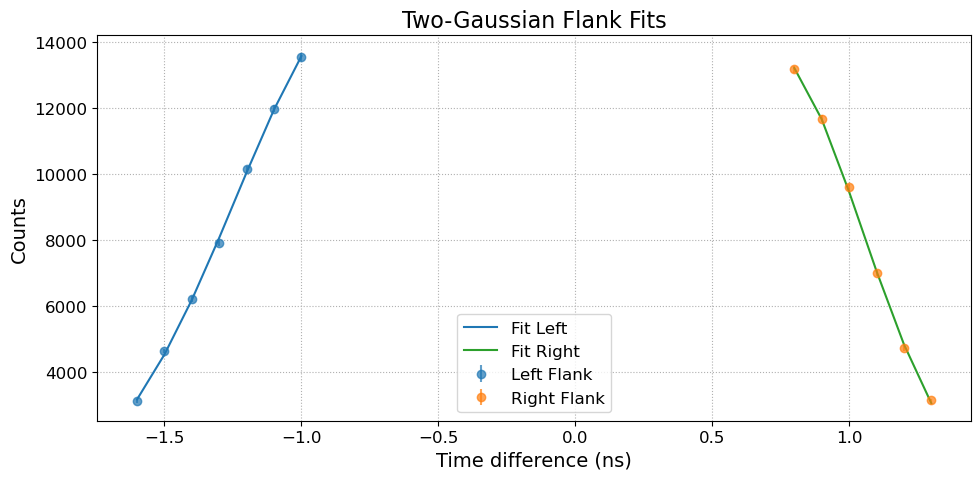

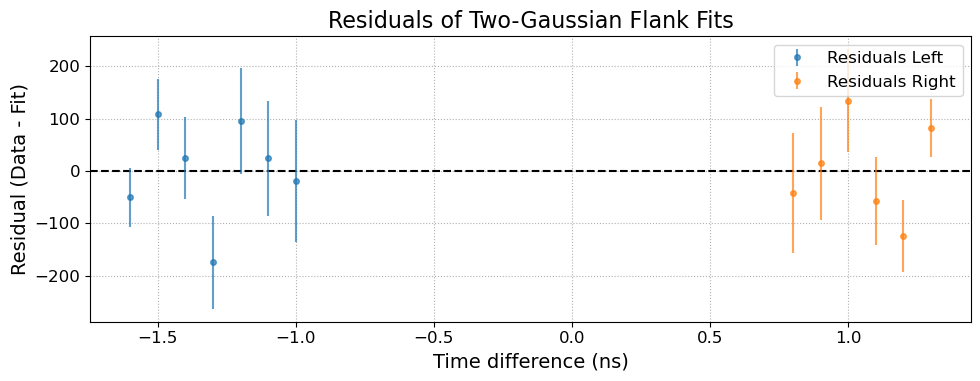


=== Processing: dltdc8_pair2_t_02_10_ns_cut ===
[✓] slope_thresh = 0.025 → χ²/ν = 427.96
[✓] slope_thresh = 0.035 → χ²/ν = 425.56
[✓] slope_thresh = 0.045 → χ²/ν = 425.56
[✓] slope_thresh = 0.055 → χ²/ν = 425.56
[✓] slope_thresh = 0.065 → χ²/ν = 398.55
[✓] slope_thresh = 0.075 → χ²/ν = 398.55
[✓] slope_thresh = 0.085 → χ²/ν = 418.73
[✓] slope_thresh = 0.095 → χ²/ν = 418.73
[✓] slope_thresh = 0.105 → χ²/ν = 418.73
[✓] slope_thresh = 0.115 → χ²/ν = 445.89
[✓] slope_thresh = 0.125 → χ²/ν = 445.89
[✓] slope_thresh = 0.135 → χ²/ν = 433.05
[✓] slope_thresh = 0.145 → χ²/ν = 433.05
[✓] slope_thresh = 0.155 → χ²/ν = 433.05
[✓] slope_thresh = 0.165 → χ²/ν = 433.05
[✓] slope_thresh = 0.175 → χ²/ν = 167.90
[✓] slope_thresh = 0.185 → χ²/ν = 167.90
[✓] slope_thresh = 0.195 → χ²/ν = 167.90
[✓] slope_thresh = 0.205 → χ²/ν = 167.90
[✓] slope_thresh = 0.215 → χ²/ν = 167.90
[✓] slope_thresh = 0.225 → χ²/ν = 167.41
[✓] slope_thresh = 0.235 → χ²/ν = 167.41
[✓] slope_thresh = 0.245 → χ²/ν = 3.35
[✓] slope_

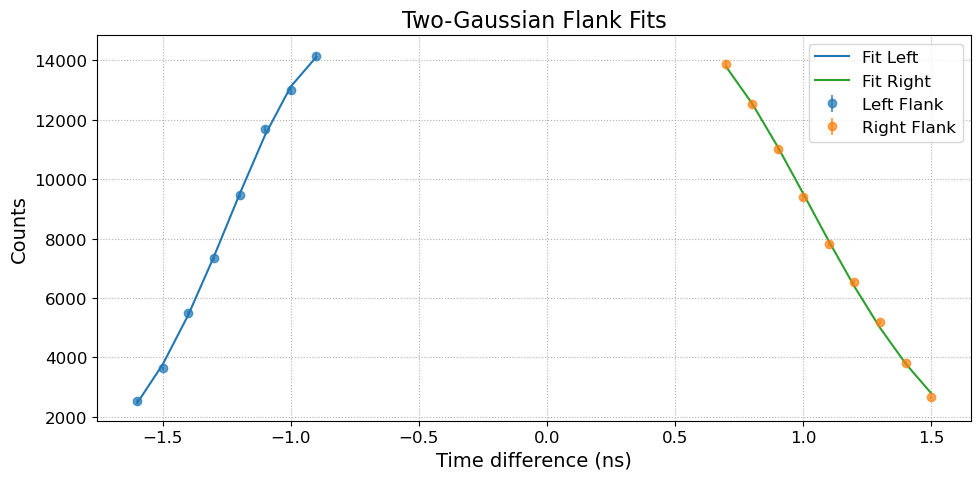

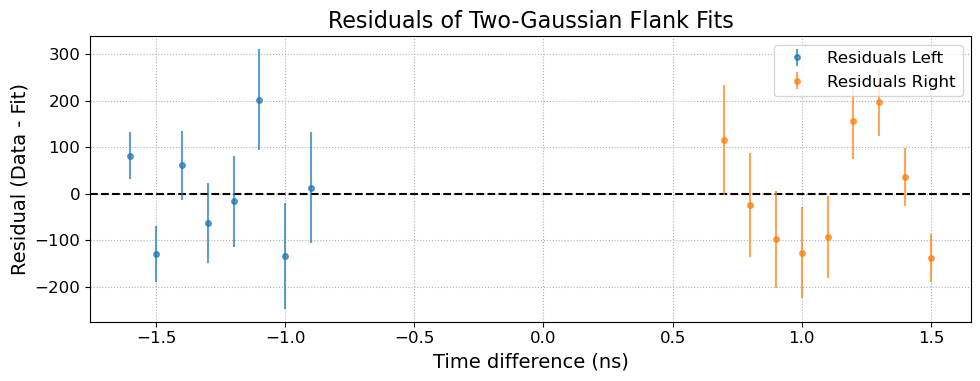


=== Processing: dltdc8_pair3_t_03_11_ns_cut ===
[✓] slope_thresh = 0.025 → χ²/ν = 64.19
[✓] slope_thresh = 0.035 → χ²/ν = 55.85
[✓] slope_thresh = 0.045 → χ²/ν = 55.85
[✓] slope_thresh = 0.055 → χ²/ν = 55.85
[✓] slope_thresh = 0.065 → χ²/ν = 55.85
[✓] slope_thresh = 0.075 → χ²/ν = 55.85
[✓] slope_thresh = 0.085 → χ²/ν = 55.85
[✓] slope_thresh = 0.095 → χ²/ν = 55.85
[✓] slope_thresh = 0.105 → χ²/ν = 55.85
[✓] slope_thresh = 0.115 → χ²/ν = 55.85
[✓] slope_thresh = 0.125 → χ²/ν = 57.36
[✓] slope_thresh = 0.135 → χ²/ν = 57.36
[✓] slope_thresh = 0.145 → χ²/ν = 61.41
[✓] slope_thresh = 0.155 → χ²/ν = 65.28
[✓] slope_thresh = 0.165 → χ²/ν = 65.81
[✓] slope_thresh = 0.175 → χ²/ν = 65.81
[✓] slope_thresh = 0.185 → χ²/ν = 65.81
[✓] slope_thresh = 0.195 → χ²/ν = 65.81
[✓] slope_thresh = 0.205 → χ²/ν = 70.58
[✓] slope_thresh = 0.215 → χ²/ν = 70.58
[✓] slope_thresh = 0.225 → χ²/ν = 56.83
[✓] slope_thresh = 0.235 → χ²/ν = 56.83
[✓] slope_thresh = 0.245 → χ²/ν = 56.83
[✓] slope_thresh = 0.255 → χ²/ν

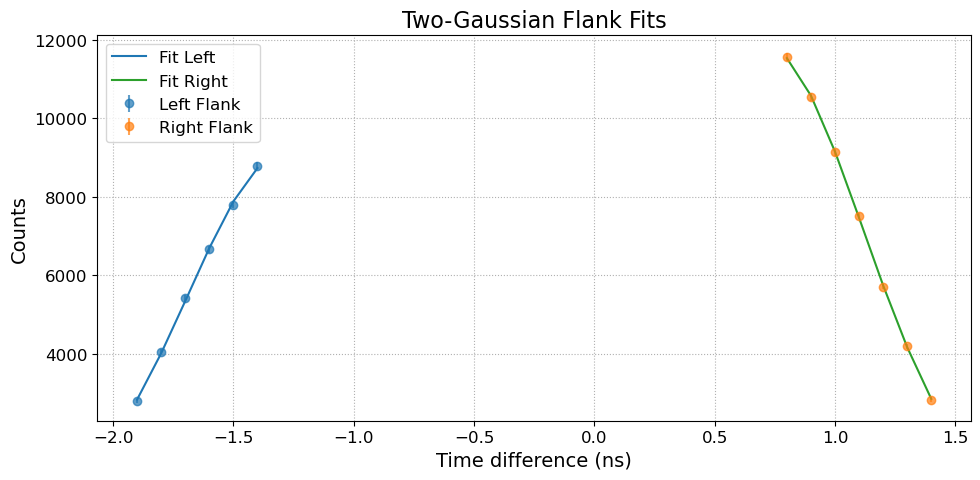

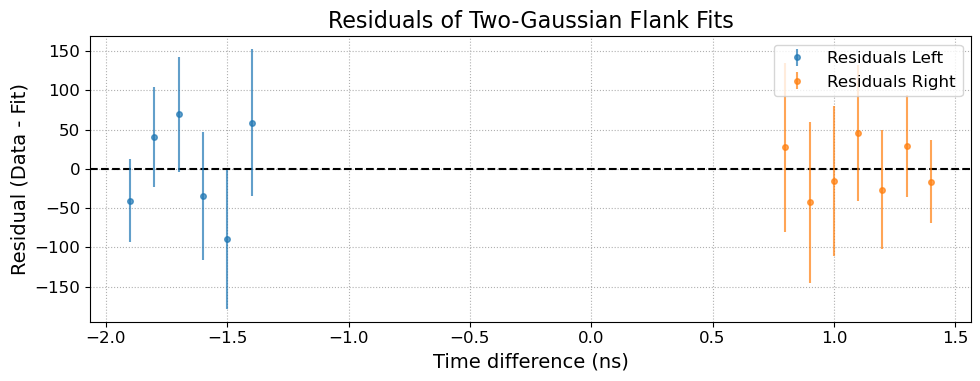


=== Processing: dltdc8_pair4_t_04_12_ns_cut ===
[✓] slope_thresh = 0.025 → χ²/ν = 549.80
[✓] slope_thresh = 0.035 → χ²/ν = 585.70
[✓] slope_thresh = 0.045 → χ²/ν = 627.50
[✓] slope_thresh = 0.055 → χ²/ν = 643.11
[✓] slope_thresh = 0.065 → χ²/ν = 673.26
[✓] slope_thresh = 0.075 → χ²/ν = 673.26
[✓] slope_thresh = 0.085 → χ²/ν = 673.26
[✓] slope_thresh = 0.095 → χ²/ν = 673.26
[✓] slope_thresh = 0.105 → χ²/ν = 673.26
[✓] slope_thresh = 0.115 → χ²/ν = 644.37
[✓] slope_thresh = 0.125 → χ²/ν = 644.37
[✓] slope_thresh = 0.135 → χ²/ν = 644.37
[✓] slope_thresh = 0.145 → χ²/ν = 644.37
[✓] slope_thresh = 0.155 → χ²/ν = 296.63
[✓] slope_thresh = 0.165 → χ²/ν = 316.47
[✓] slope_thresh = 0.175 → χ²/ν = 360.93
[✓] slope_thresh = 0.185 → χ²/ν = 360.93
[✓] slope_thresh = 0.195 → χ²/ν = 2.34
[✓] slope_thresh = 0.205 → χ²/ν = 2.34
[✓] slope_thresh = 0.215 → χ²/ν = 2.34
[✓] slope_thresh = 0.225 → χ²/ν = 2.34
[✓] slope_thresh = 0.235 → χ²/ν = 2.34
[✓] slope_thresh = 0.245 → χ²/ν = 2.34
[✓] slope_thresh = 0

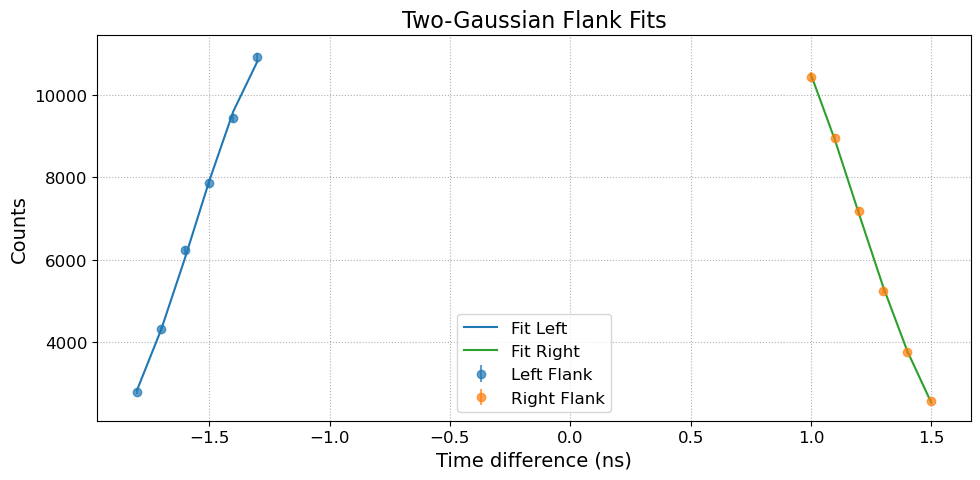

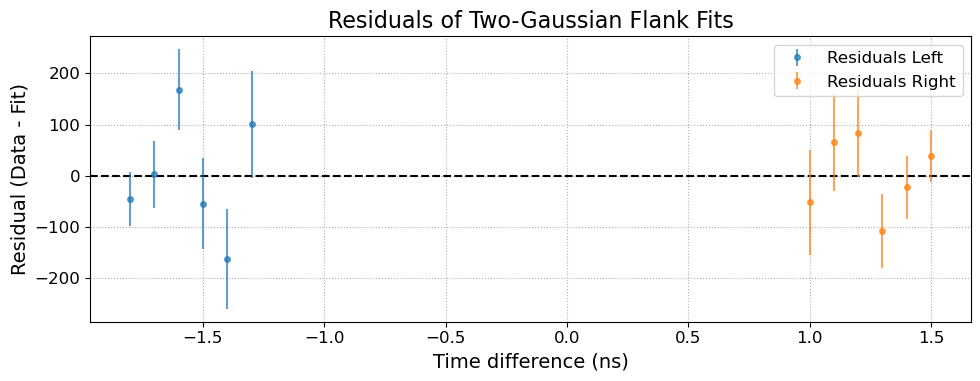


=== Processing: dltdc8_pair5_t_05_13_ns_cut ===
⚠️ Skipping dltdc8_pair5_t_05_13_ns_cut: histogram is empty.

=== Processing: dltdc8_pair6_t_06_14_ns_cut ===
⚠️ Skipping dltdc8_pair6_t_06_14_ns_cut: histogram is empty.

=== Processing: dltdc8_pair7_t_07_15_ns_cut ===
[✓] slope_thresh = 0.025 → χ²/ν = 863.21
[✓] slope_thresh = 0.035 → χ²/ν = 863.21
[✓] slope_thresh = 0.045 → χ²/ν = 438.02
[✓] slope_thresh = 0.055 → χ²/ν = 0.64
[✓] slope_thresh = 0.065 → χ²/ν = 0.64
[✓] slope_thresh = 0.075 → χ²/ν = 0.64
[✓] slope_thresh = 0.085 → χ²/ν = 0.64
[✓] slope_thresh = 0.095 → χ²/ν = 0.64
[✓] slope_thresh = 0.105 → χ²/ν = 0.64
[✓] slope_thresh = 0.115 → χ²/ν = 0.64
[✓] slope_thresh = 0.125 → χ²/ν = 0.64
[✓] slope_thresh = 0.135 → χ²/ν = 0.64
[✓] slope_thresh = 0.145 → χ²/ν = 0.64
[✓] slope_thresh = 0.155 → χ²/ν = 0.64
[✓] slope_thresh = 0.165 → χ²/ν = 0.64
[✓] slope_thresh = 0.175 → χ²/ν = 0.64
[✓] slope_thresh = 0.185 → χ²/ν = 0.64
[✓] slope_thresh = 0.195 → χ²/ν = 0.64
[✓] slope_thresh = 0.20

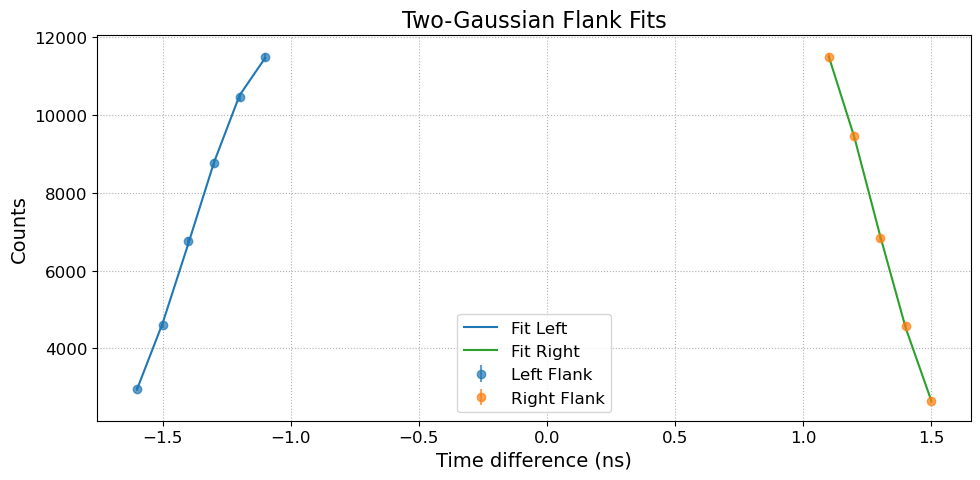

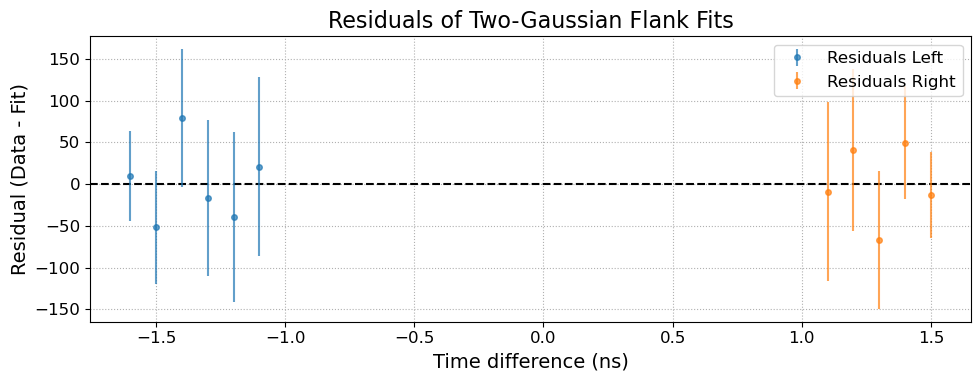


=== Processing: dltdc8_pair8_t_08_16_ns_cut ===
[✓] slope_thresh = 0.025 → χ²/ν = 0.57
[✓] slope_thresh = 0.035 → χ²/ν = 0.57
[✓] slope_thresh = 0.045 → χ²/ν = 0.57
[✓] slope_thresh = 0.055 → χ²/ν = 0.57
[✓] slope_thresh = 0.065 → χ²/ν = 0.57
[✓] slope_thresh = 0.075 → χ²/ν = 0.57
[✓] slope_thresh = 0.085 → χ²/ν = 0.57
[✓] slope_thresh = 0.095 → χ²/ν = 0.57
[✓] slope_thresh = 0.105 → χ²/ν = 0.57
[✓] slope_thresh = 0.115 → χ²/ν = 0.57
[✓] slope_thresh = 0.125 → χ²/ν = 0.57
[✓] slope_thresh = 0.135 → χ²/ν = 0.57
[✓] slope_thresh = 0.145 → χ²/ν = 0.57
[✓] slope_thresh = 0.155 → χ²/ν = 0.57
[✓] slope_thresh = 0.165 → χ²/ν = 0.57
[✓] slope_thresh = 0.175 → χ²/ν = 0.57
[✓] slope_thresh = 0.185 → χ²/ν = 0.57
[✓] slope_thresh = 0.195 → χ²/ν = 0.57
[✓] slope_thresh = 0.205 → χ²/ν = 0.57
[✓] slope_thresh = 0.215 → χ²/ν = 0.57
[✓] slope_thresh = 0.225 → χ²/ν = 0.57
[✓] slope_thresh = 0.235 → χ²/ν = 0.41
[✓] slope_thresh = 0.245 → χ²/ν = 0.41
[✓] slope_thresh = 0.255 → χ²/ν = 0.41
[✓] slope_thres

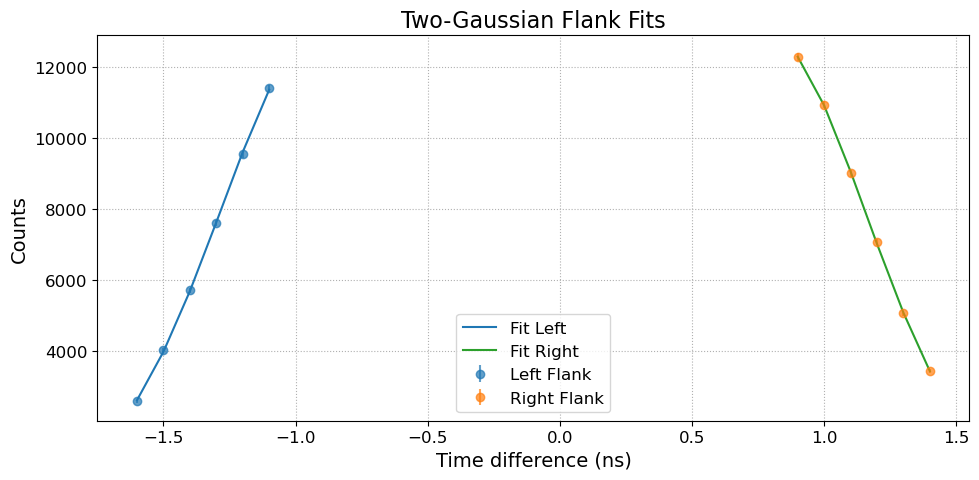

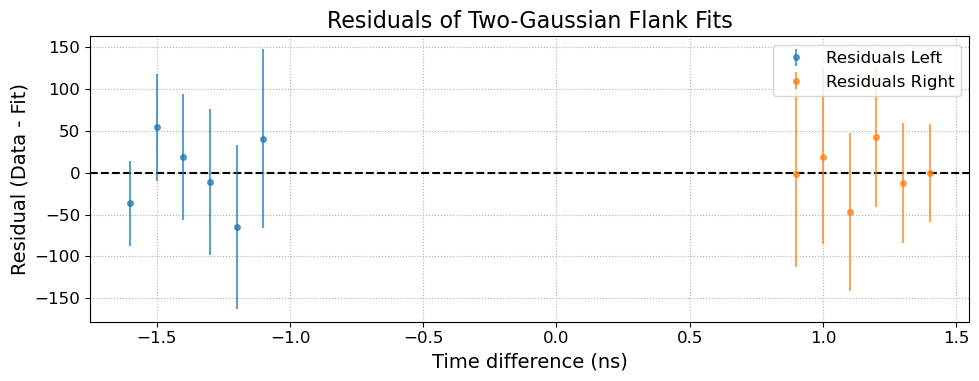

📁 Results saved to 'timing_resolution_results.csv'


In [28]:
import pandas as pd
""""
histogram_names = [
    "dltdc16_sc01_t_01_09_ns_cut_twc",
    "dltdc16_sc02_t_02_10_ns_cut_twc",
    "dltdc16_sc03_t_03_11_ns_cut_twc",
    "dltdc16_sc04_t_04_12_ns_cut_twc",
    "dltdc16_sc05_t_05_13_ns_cut_twc",
    "dltdc16_sc06_t_06_14_ns_cut_twc",
    "dltdc16_sc07_t_07_15_ns_cut_twc",
    "dltdc16_sc08_t_08_16_ns_cut_twc",
    "dltdc16_sc09_t_17_25_ns_cut_twc",
    "dltdc16_sc10_t_18_26_ns_cut_twc",
    "dltdc16_sc11_t_19_27_ns_cut_twc",
    "dltdc16_sc12_t_20_28_ns_cut_twc",
    "dltdc16_sc13_t_21_29_ns_cut_twc",
    "dltdc16_sc14_t_22_30_ns_cut_twc",
    "dltdc16_sc15_t_23_31_ns_cut_twc",
    "dltdc16_sc16_t_24_32_ns_cut_twc",
]
"""
histogram_names = [
    "dltdc8_pair1_t_01_09_ns_cut",
    "dltdc8_pair2_t_02_10_ns_cut",
    "dltdc8_pair3_t_03_11_ns_cut",
    "dltdc8_pair4_t_04_12_ns_cut",
    "dltdc8_pair5_t_05_13_ns_cut",
    "dltdc8_pair6_t_06_14_ns_cut",
    "dltdc8_pair7_t_07_15_ns_cut",
    "dltdc8_pair8_t_08_16_ns_cut"
]

results = []
buffer_bins = 0

with uproot.open("/Users/sidne/DarkLight 2025/output00362.root") as f:
    for fileID in histogram_names:
        print(f"\n=== Processing: {fileID} ===")
        timeDiff = f["dltdc8"][fileID].to_numpy()[0]
        x_root = f["dltdc8"][fileID].to_numpy()[1][:-1]
        # Skip empty histograms
        if np.sum(timeDiff) == 0:
            print(f"⚠️ Skipping {fileID}: histogram is empty.")
            continue
       
        global_max = np.max(timeDiff)
        first = next((i for i, y in enumerate(timeDiff) if y > threshold * global_max), None)
        last = next((i for i, y in enumerate(timeDiff[::-1]) if y > threshold * global_max), None)
        last = len(timeDiff) - 1 - last if last is not None else None
        if first is None or last is None:
            print(f"⚠️ Skipping {fileID}: Could not find threshold crossings in one or both halves.")
            continue
    
        x_root_cut = x_root[first:last + 1]
        timeDiff_cut = timeDiff[first:last + 1]
        y_err_cut = np.sqrt(np.clip(timeDiff_cut, 1, None))
        peakHeight = max(timeDiff_cut)
        countsChopped_cut = np.minimum(timeDiff_cut, (1 - threshold) * peakHeight)

        result = auto_fit_two_flanks_gaussian(
            x_root_cut
            countsChopped_cut,
            initial_thresh=0.025,
            buffer_bins=buffer_bins,
            max_iterations=30,
            verbose=True
        )

        if result[0] is not None:
            _, _, sigma_avg, chi2red, best_thresh = result
            print(f"✅ Best result for {fileID}:")
            print(f"   σ = {sigma_avg:.4f} ns")
            print(f"   χ²/ν = {chi2red:.2f}")
            print(f"   slope threshold = {best_thresh:.3f}")

            # Run final fit with best slope threshold
            flank_mask = get_flank_mask_slope_based(
                x_root_cut, countsChopped_cut,
                buffer_bins=buffer_bins,
                slope_threshold_frac=best_thresh
            )
            x_flank_g = x_root_cut[flank_mask]
            y_flank_g = countsChopped_cut[flank_mask]
            sigma_avg, sigma_avg_err, sigma_l, sigma_err_l, chi2red_l, sigma_r, sigma_err_r, chi2red_r = fit_two_flanks_gaussian(
                x_flank_g, y_flank_g, return_all=True
            )

            results.append([
                fileID,
                sigma_avg, sigma_avg_err,
                sigma_r, sigma_err_r, chi2red_r,
                sigma_l, sigma_err_l, chi2red_l
            ])
        else:
            print(f"❌ No acceptable fit found for {fileID}")

# Save results to CSV
df = pd.DataFrame(results, columns=[
    "File Name",
    "σ_avg", "σ_avg_err",
    "σ_r", "σ_r_err", "χ²/ν_r",
    "σ_l", "σ_l_err", "χ²/ν_l"
])
df.to_csv("timing_resolution_results.csv", index=False)
print("📁 Results saved to 'timing_resolution_results.csv'")

### Only use this when you want general ideas on how to fit a bunch of files. Once you select a optimal threshold usally just run it again with that threshold on the main fit function